# Clustering-Verfahren

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import show, cm, axis
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

from collections import Counter
import random
import string
import sys

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture 
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, v_measure_score
from yellowbrick.text import TSNEVisualizer, UMAPVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage

import markov_clustering as mc

import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/teresa/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
happy_all = pd.read_csv('happy_preprocessed_onlygroundtruth.csv')
happy_day = pd.read_csv('happy_preprocessed_24h.csv')
happy_months = pd.read_csv('happy_preprocessed_3m.csv')
age_all = pd.read_csv('happy_combined_by_age_all.csv')
age_day = pd.read_csv('happy_combined_by_age_day.csv')
age_months = pd.read_csv('happy_combined_by_age_months.csv')
wid_all = pd.read_csv('happy_combined_by_wid_all.csv')
wid_day = pd.read_csv('happy_combined_by_wid_day.csv')
wid_months = pd.read_csv('happy_combined_by_wid_months.csv')

## Vorbereitung der Daten

In [3]:
def tfidf(data):
    tf_idf_vectorizor = TfidfVectorizer()
    tf_idf = tf_idf_vectorizor.fit_transform(data)
    tf_idf_norm = normalize(tf_idf)
    tf_idf_array = tf_idf_norm.toarray()
    return tf_idf_array

In [5]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

In [6]:
def visualise_PCA(Y, hue, style, title, path=None):
    markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
    plt.figure(figsize=(15,10))
    sns.set_style("white")
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path+'_PCA.png', bbox_inches = "tight")
    plt.clf()
    plt.close()

In [7]:
def visualise_TSNE(Y, hue, style, title, perplexity=50, path=None):
    X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(Y)
    X_embedded = TSNE(n_components=2, perplexity=perplexity, n_iter=1000,learning_rate=10, verbose=False).fit_transform(X_reduced)
        
    markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
    plt.figure(figsize=(15,10))
    sns.set_style("white")
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path+'_TSNE.png', bbox_inches = "tight")
    plt.clf()
    plt.close()

In [8]:
def visualise_UMAP(docs, labels, title, path=None):

    umap = UMAPVisualizer(metric='cosine')
    plt.figure(figsize=(15,10))
    umap.fit(docs, labels)
    plt.title(title)
    if path is not None:
        plt.savefig(path+'_UMAP.png', bbox_inches = "tight")
    umap.show()
    plt.clf()
    plt.close()

/home/teresa/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/teresa/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/teresa/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


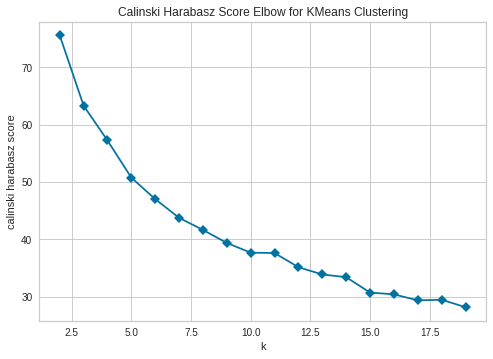

In [14]:
from yellowbrick.cluster import KElbowVisualizer

tf_idf_array = tfidf(happy_day.preprocessed)

visualizer = KElbowVisualizer(KMeans(), k=(2,20), timings=False, metric='calinski_harabasz')
visualizer.fit(tf_idf_array)
plt.savefig('Elbow_happy_day')
visualizer.show()

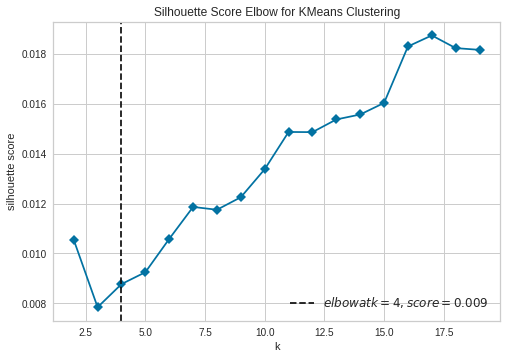

In [15]:
from yellowbrick.cluster import KElbowVisualizer

tf_idf_array = tfidf(happy_day.preprocessed)

visualizer = KElbowVisualizer(KMeans(), k=(2,20), timings=False, metric='silhouette')
visualizer.fit(tf_idf_array)
plt.savefig('Silhouette2_happy_day')
visualizer.show()

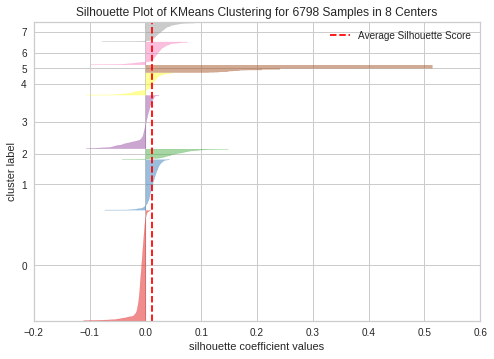

In [13]:
 from yellowbrick.cluster import SilhouetteVisualizer
model = SilhouetteVisualizer(KMeans(), k=(2,20))
model.fit(tf_idf_array)
plt.savefig('Silhouette_happy_day')
model.show()

In [75]:
def get_cluster_dfs(df, cluster):
    "Get one df with all entries from one cluster for all clusters"
    return [df[cluster == i] for i in np.unique(cluster)]

In [114]:
def print_clusters(dfs,hue, path):
    """
    Prints some information for each cluster. Usefull for getting a first sight on the clustering.
    """
    dic={}
    for index, cluster_df in enumerate(dfs):
#         print(f'Cluster {index}: {np.unique(cluster_df.ground_truth_category)}')
        c = Counter(cluster_df[hue])
#         s = ' '.join(list(np.unique(cluster_df.ground_truth_category))
#         dic[index]=s
        keys = list(c.keys())
        c['Total number of tokens in cluster'] = cluster_df.length.sum()
        c['Total number of texts in cluster'] = len(cluster_df)
#         print('-'*60)
        dic[index]=c
    x = pd.DataFrame.from_dict(dic, orient='index')
    keys.append('Total number of tokens in cluster')
    keys.append('Total number of texts in cluster')
    x = x[keys]
    x = x.fillna(0)
    x = x.astype(int)
    if path is not None:
        x.to_csv(path+'_clusterattribution.csv')
    return x
# print_clusters(kmeans_dfs, hue='ground_truth_category', path=None)

In [107]:
def prediction_evaluation(data, hue, prediction, path_name):
    df = pd.DataFrame()
    df['category'] = data[hue]
    df['predicted'] = prediction
    genre_group = pd.DataFrame(df.groupby('predicted')['category'].apply(lambda x: x.value_counts()))
    genre_group.to_csv(path_name+'evaluation.csv')
    df.to_csv(path_name+'df.csv')
    return df

In [108]:
def cluster_evaluation(df,orig, category, cluster):
    evaluation = []
    for i, row in df.iterrows():
        if row.category==category and row.predicted==cluster:
            evaluation.append(orig.iloc[i])
    evaluate = pd.DataFrame(evaluation)
    return evaluate

## K-Means 

In [115]:
def kmeans(data, df, k, text, hues, path):
    kmeans = KMeans(n_clusters=k, max_iter=600, algorithm = 'auto')
    fitted = kmeans.fit(data)
    prediction = kmeans.predict(data)
    
    Y = compute_PCA(data)
    
    for hue in hues:
        print(hue)
        if hue in df.columns:
            labels=df[hue].values
            kmeans_ari = adjusted_rand_score(labels, kmeans.labels_)
            print(f"Adjusted Rand Score for K-Means: {kmeans_ari}.")
            kmeans_vm = v_measure_score(labels, kmeans.labels_)
            print(f"V-Measure for K-Means: {kmeans_vm}.")
            
            path_name = path+ds_name+'_kmeans_'+hue
            print(path)
            kmeans_dfs = get_cluster_dfs(df, prediction)
            print_clusters(kmeans_dfs,hue,path_name)

            visualise_PCA(Y, df[hue], prediction,'PCA', path=path_name)
            visualise_TSNE(data, df[hue], prediction,'TSNE', perplexity=50, path=path_name)
#     visualise_UMAP(tf_idf_array, df[hue], 'UMAP',path)
            prediction_evaluation(df, hue, prediction, path_name)
    return prediction

## HC

In [81]:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

In [169]:
def getClusterAssignments(X, den, labels):
    cluster_idxs = dict()
    cluster_rows = dict()
    colors_nums = dict()
    col_num=0
    for c in np.unique(den['color_list']):
        cluster_idxs[c] = []
        colors_nums[c] = col_num
        cluster_rows[col_num] = []
        col_num = col_num + 1

    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    rows_clusters = dict()
    for c, l in cluster_idxs.items():
        i_l = [den['ivl'][i] for i in l]
        col_num = colors_nums[c]
        cluster_rows[col_num] = i_l
        for i in i_l:
            rows_clusters[i] = col_num

    y_pred = []
    for i in labels:
#         if i in rows_clusters.keys():
        y_pred = np.append(y_pred, int(rows_clusters[i]))

    return y_pred

In [170]:
def hc(data, df, text, hues, path):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(data)
    if type(data) == list:
        link_matrix = linkage_matrix(len(data), model.children_, model.distances_)
#         X = len(data)
    else:
        link_matrix = linkage_matrix(data.shape[0], model.children_, model.distances_)
#         X = data.shape[0]
    for hue in hues:
        if hue in df.columns:
            plt.figure(figsize=(70,20))
            plt.title('HC')
            den = dendrogram(link_matrix, labels = (df[hue].values), leaf_font_size=20)
            path_name = path+ds_name+'_HC_'+hue
            plt.savefig(path_name+'.png', bbox_inches = "tight")
            plt.clf()
            plt.close()
            
            X=df
            labels=df[hue].values
            y_pred = getClusterAssignments(X, den, labels)
            print(labels, '\n', y_pred)
            hc_ari = adjusted_rand_score(labels, y_pred)
            print(f"Adjusted Rand Score for HC: {hc_ari}.")
            hc_vm = v_measure_score(labels, y_pred)
            print(f"V-Measure for HC: {hc_vm}.")


## Gaussian Mixture Model

### BIC und AIC

In [11]:
n_components = np.arange(1, 20)
BIC = np.zeros(n_components.shape)
AIC = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    clf = GaussianMixture(n_components=n,
              covariance_type='tied')
    clf.fit(tf_idf_array)

    AIC[i] = clf.aic(tf_idf_array)
    BIC[i] = clf.bic(tf_idf_array)

plt.figure(figsize=(15,15))
plt.plot(n_components, AIC, label='AIC')
plt.plot(n_components, BIC, label='BIC')
plt.legend(loc=0)
plt.xlabel('n_components')
plt.ylabel('AIC / BIC')
plt.savefig('GMM_AIC_BIC_spherical')

### hard clustering

In [124]:
def gmm_hard(k,data, df, text, hues, path):
    gmm = GaussianMixture(n_components=k, n_init=10, covariance_type='spherical').fit(data)
    prediction = gmm.predict(data)
    Y = compute_PCA(data)
    plt.figure(figsize=(15,10))

#     # detect anomalies
#     densities = gmm.score_samples(data)
#     density_threshold = np.percentile(densities, 4)
    
#     anomalies = data[densities < density_threshold]

    #hier PCA einfügen; und TSNE? --> ohne Anomalies
    if path is not None:    
        for hue in hues:
            if hue in df.columns:
                labels = df[hue].values
                gmm_ari = adjusted_rand_score(labels, prediction)
                print(f"Adjusted Rand Score for Gaussian Mixture Model hard: {gmm_ari}.")
                gmm_vm = v_measure_score(labels, prediction)
                print(f"V-Measure for Gaussian Mixture Model hard: {gmm_vm}.")
                
                path_name = path+ds_name+'_gmm_hard_'+hue

                gmm_dfs = get_cluster_dfs(df, prediction)
                print_clusters(gmm_dfs, hue, path_name)

                markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
                sns.scatterplot(Y[:, 0], Y[:, 1],hue=df[hue], style=prediction, markers=markers,palette=sns.color_palette("hls", len(np.unique(df[hue]))))
#                 plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
                plt.savefig(path_name+'.png')
                plt.clf()
                plt.close()
                prediction_evaluation(df, hue, prediction, path_name)

    return gmm, prediction

### soft clustering

In [117]:
def gmm_soft(data, gmm, prediction, df, text, hues, path):

    probs = gmm.predict_proba(data)
#     print(probs[:5])
    size = 50 * probs.max(1) ** 2  # square emphasizes differences

    perplexity=50
    X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(data)
    X_embedded = TSNE(n_components=2, perplexity=perplexity, n_iter=1000,learning_rate=10, verbose=False).fit_transform(X_reduced)
        
    
    if path is not None:
        for hue in hues:
            if hue in df.columns:

                path_name = path+ds_name+'_gmm_soft_'+hue

                gmm_dfs = get_cluster_dfs(df, prediction)
                print_clusters(gmm_dfs, hue, path_name)

                markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
                plt.figure(figsize=(15,10))
                sns.set_style("white")
                sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=df[hue], style=prediction, size=size, markers=markers, palette=sns.color_palette("hls", len(np.unique(df[hue]))))
                plt.title('GMM Soft')
                plt.savefig(path_name+'_TSNE.png', bbox_inches = "tight")
                plt.clf()
                plt.close()
    return probs

In [87]:
def gmm_outliers(df, probs):
    # Außreißer mit Wahrscheinlichkeitszuordnungen
    if 'ground_truth_category' not in df.columns:
        d = {'wid': df.wid, 'cleaned_hm': df.cleaned_hm, 'country': df.country, 'gender': df.gender, 'marital':df.marital, 'parenthood':df.parenthood}
    elif 'hmid' in df.columns:
        d = {'wid': df.wid, 'cleaned_hm': df.cleaned_hm, 'category':happy_day.ground_truth_category,'country': df.country, 'gender': df.gender, 'marital':df.marital, 'parenthood':df.parenthood}
    elif 'wid' not in df.columns:
        d = {'age_range':df.age_range, 'category': df.ground_truth_category, 'cleaned_hm': df.cleaned_hm}    
            
    data = pd.DataFrame(data=d)
    data = data.reset_index()
    p = pd.DataFrame(data=probs)
    probabilities = data.join(p, how='outer')
    probabilities.drop('index', axis=1, inplace=True)

    cols = list(d.keys())

    probability = pd.DataFrame()
    for i in range(len(probs[0])):
        cols.append(str(i))
        p = probabilities[probabilities.iloc[:, probabilities.columns.get_loc(i)]!= 1.0]
        p = p[p.iloc[:, p.columns.get_loc(i)]!= 0.0]
        probability = pd.concat([probability, p], ignore_index=True)
    probability.columns = cols
    probability = probability.drop_duplicates()
#     path = path+ds_name+'_gmm_outliers_'+hue+'.csv'
    probability.to_csv(path+ds_name+'_gmm_outliers_'+'.csv')
    return probability

### Bayes GMM 

In [126]:
def gmm_bayes(k,data, df, text, hues, path):
    Y = compute_PCA(data)

    bgmm = BayesianGaussianMixture(n_components=k+5, n_init=10, covariance_type ='diag').fit(data) 
    # Y = compute_PCA(tf_idf_array)

    prediction = bgmm.predict(data) 
    # print((prediction)) 
    
    for hue in hues: 
        if hue in df.columns:
            labels = df[hue].values
            bgmm_ari = adjusted_rand_score(labels, prediction)
            print(f"Adjusted Rand Score for Gaussian Mixture Model Bayes: {bgmm_ari}.")
            bgmm_vm = v_measure_score(labels, prediction)
            print(f"V-Measure for Gaussian Mixture Model Bayes: {bgmm_vm}.")

            path_name = path+ds_name+'_gmm_bayes_'+hue

            gmm_dfs = get_cluster_dfs(df, prediction)
            print_clusters(gmm_dfs, hue, path_name)
            visualise_PCA(Y, df[hue], prediction, 'Bayes GMM - PCA', path_name)
            visualise_TSNE(data, df[hue], prediction, 'Bayes GMM - TSNE', perplexity=50, path=path_name)
            prediction_evaluation(df, hue, prediction, path_name)

### Markov Chain Clustering

In [94]:
def prepare_nodes(data, df, text, numnodes):
    Y = compute_PCA(data)
    pos=[]
    pos.append([i for i in range(numnodes)])
    YY = list(map(tuple, Y.tolist()))
    positions = set(zip(pos[0], YY))
    pos_dic = dict((x, y) for x, y in positions)
    return pos_dic

In [95]:
def matrix_clusters(pos_dic, numnodes):
    # number of nodes to use
    numnodes = numnodes

    # use networkx to generate the graph
    network = nx.random_geometric_graph(numnodes, 0.3, pos=pos_dic)

    # then get the adjacency matrix (in sparse form)
    matrix = nx.to_scipy_sparse_matrix(network)

    result = mc.run_mcl(matrix)           # run MCL with default parameters
    clusters = mc.get_clusters(result)    # get clusters
    return matrix, clusters

In [96]:
# function taken from markov-clustering project (https://github.com/guyallard/markov_clustering)
    
def draw_graph(matrix, clusters,path, **kwargs):
    """
    Visualize the clustering
    
    :param matrix: The unprocessed adjacency matrix
    :param clusters: list of tuples containing clusters as returned
                     by 'get_clusters'
    :param kwargs: Additional keyword arguments to be passed to
                   networkx.draw_networkx
    """
    # make a networkx graph from the adjacency matrix
    graph = nx.Graph(matrix)
    
    # map node to cluster id for colors
    cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
    colors = [cluster_map[i] for i in range(len(graph.nodes()))]
    
    # if colormap not specified in kwargs, use a default
    if not kwargs.get("cmap", False):
        kwargs["cmap"] = cm.tab20
    # draw
    path_name = path+ds_name+'_markov_'+hue
    
    nx.draw_networkx(G=graph,node_color=colors, **kwargs)

    axis("off")
    plt.savefig(path_name+'_nx.png')
    show(block=False)


In [119]:
def draw_graph_plt(matrix, clusters, pos_dic, hues, path):
    graph = nx.Graph(matrix)
    cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
    
    x=[]
    y=[]
    for p in pos_dic.values():
        x.append(p[0])
        y.append(p[1])
    style=[]    
    for k in pos_dic.keys():
        style.append(cluster_map[k])
    for hue in hues:
        if hue in df.columns:

            path_name = path+ds_name+'_markov_'+hue

            clustering = get_cluster_dfs(df, list(cluster_map.values()))
            print_clusters(clustering, hue, path_name)
        
            marker = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
            if len(style)<= len(marker):
                plt.figure(figsize=(15,10))
                sns.set_style("white")
                sns.scatterplot(x,y,hue=df[hue], style=style,markers=marker)
                plt.savefig(path_name+'_nx.png')
                plt.clf()
                plt.close()
            analyse_marvok_clusters(clusters,path, hue)
    return cluster_map
# nx.draw_networkx(G=graph,node_color=colors, node_size=50, with_labels=False, edge_color="silver")


In [98]:
# try different nx visualisations
# p=nx.kamada_kawai_layout(nx.Graph(matrix),scale=2)
# p=nx.spring_layout(nx.Graph(matrix),k=0.3)
# p=pos_dic
# draw_graph(matrix, clusters, pos=p, node_size=50, with_labels=False, edge_color="silver", path=path)

In [99]:
def analyse_marvok_clusters(clusters, path, hue):
    ''' Creates DataFrame with cluster assignments for happy moments. '''
    clustered_moments = []
    attribution = []
#     df.reset_index()
    for i, cluster in enumerate(clusters):
        for node in cluster:
            attribution.append(str(i))
            clustered_moments.append(df.iloc[node])
    cluster_res = pd.DataFrame(clustered_moments)
    cluster_res['cluster']=attribution
    path_name = path+ds_name+'_markov_'+hue
    cluster_res.to_csv(path_name+'_cluster.csv')

    prediction_evaluation(df, hue, attribution, path_name)
    
    return cluster_res
# r = analyse_marvok_clusters(clusters, path)
# r

## Vorbereitung von Samples

In [101]:
samp_happy_all = happy_all[happy_all.length>35].sample(frac=0.2)
samp_happy_day = happy_day[happy_day.length>35].sample(frac=0.2)
samp_happy_months = happy_months[happy_months.length>35].sample(frac=0.2)
samp_wid_all = wid_all[wid_all.length>50].sample(frac=0.2)
samp_wid_day = wid_day[wid_day.length>50].sample(frac=0.2)
samp_wid_months = wid_months[wid_months.length>50].sample(frac=0.2)

sample_dic = {'sample_happy_all':samp_happy_all, 'sample_happy_day':samp_happy_day, 'sample_happy_months': samp_happy_months,
              'sample_wid_all': samp_wid_all, 'sample_wid_day': samp_wid_day, 'sample_wid_months':samp_wid_months}

In [ ]:
dataset_dic = {'happy_all':happy_all[happy_all.length>35], 'happy_day':happy_day[happy_day.length>35], 'happy_months':happy_months[happy_months.length>35]}
               'age_all':age_all, 'age_day':age_day, 'age_months':age_months, 
               'wid_all':wid_all[wid_all.length>50],'wid_day':wid_day[wid_day.length>50], 'wid_months':wid_months[wid_months.length>50]}

## Pipeline mit TF-IDF

In [172]:
hues = ['ground_truth_category', 'age_range', 'country', 'relation_age','gender', 'marital','parenthood', 'topic'] 
addit_feature = 'ground_truth_category'
text = 'preprocessed'
path = 'visualisations/clustering/'
k = 8

for name, df in dataset_dic.items():
    print(name)
    ds_name=name
    
#     # use multiple input features
#     tf_idf = TfidfVectorizer().fit_transform(df[text], df[addit_feature])
#     tf_idf_norm = normalize(tf_idf)
#     tf_idf_array = tf_idf_norm.toarray()
    
    # use one input feature
    tf_idf_array = tfidf(df[text])
    
    # K-Means
    print('K-Means')
    kmeans(tf_idf_array, df, k, text, hues, path)
    
#     hierarchical clustering
    print('HC')
    hc(tf_idf_array, df, text, hues, path)
    
    # Gaussian Mixture Model
    print('GMM')
    gmm, prediction = gmm_hard(k, tf_idf_array, df, text, hues, path)
    print('soft GMM')
    probs = gmm_soft(tf_idf_array, gmm, prediction, df, text, hues, path)
    print('outlier')
    gmm_outliers(df, probs)
    print('Bayes GMM')
    gmm_bayes(k, tf_idf_array, df, text, hues, path)
    
    # Markov Chain Clustering
    print('MCC')
    numnodes=len(df)
    pos_dic = prepare_nodes(tf_idf_array, df, text, numnodes)
    matrix, clusters = matrix_clusters(pos_dic, numnodes)
    cluster_map = draw_graph_plt(matrix, clusters, pos_dic, hues, path)

rel_age
['bonding' 'enjoy_the_moment' 'leisure' 'achievement' 'affection'
 'bonding' 'enjoy_the_moment' 'exercise' 'leisure' 'nature' 'achievement'
 'affection' 'bonding' 'enjoy_the_moment' 'exercise' 'leisure' 'nature'
 'achievement' 'affection' 'bonding' 'enjoy_the_moment' 'exercise'
 'leisure' 'nature' 'achievement' 'affection' 'bonding' 'enjoy_the_moment'
 'exercise' 'leisure' 'nature' 'achievement' 'affection'
 'enjoy_the_moment' 'leisure'] 
 [3. 5. 5. 5. 5. 3. 5. 2. 5. 5. 5. 5. 3. 5. 2. 5. 5. 5. 5. 3. 5. 2. 5. 5.
 5. 5. 3. 5. 2. 5. 5. 5. 5. 5. 5.]
Adjusted Rand Score for HC: 0.1860133956497195.
V-Measure for HC: 0.5570063258350658.
bayes
['ground_truth_category'] MCC


In [416]:
print(list(rel_age[rel_age['Unnamed: 0']=='94'].stemmed))
print(list(rel_age[rel_age['Unnamed: 0']=='142'].stemmed))
print(list(rel_age[rel_age['Unnamed: 0']=='82'].stemmed))

[' I am happi becaus the indian and the cavali both won today .  someth wa on sale 50 % off that I want to buy !  I wa happi not to have to cook dinner .']
[" I took some medic that reliev soem pain .  I found a penni on the ground .  I bought a tasti sandwich for lunch at a reduc price .  I receiv a coupon . I wa abl to buy someth onlin at a discount . It felt realli good to save money .  I went to the doctor today for a checkup . I wa veri pleas to find that noth is wrong .  I 'm happi I got at least 530 good word written today on a 1000 word essay I 'm write ( `` pin ball presid '' ) about donald trump ."]
[' It wa nice to be abl to have some time to myself to catch up on my bibl read .']


## Pipeline mit Word Embeddings

In [174]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # remove commonly occurring words
    LIMIT_WORDS = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', 'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without', 'yesteri', '2s', 'toand', 'ing']
    nopunc = [char for char in mess if char not in LIMIT_WORDS]
        
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)   
    # Now just remove any stopwords

    
    return [word.lower() for word in nopunc.split()]
# Apply to entire happy dataset, column cleaned_hm
happy_day['preprocessed'] = happy_day['stemmed'].apply(text_process)
happy_day.head(1)

,Unnamed: 0,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,...,stemmed,preprocessed,age,country,gender,marital,parenthood,age_range,relation_age,topic
0,6,40281,2053,24h,I played a game for about half an hour.,I played a game for about half an hour.,True,1,leisure,leisure,...,I play a game for about half an hour .,"[i, play, a, game, for, about, half, an, hour, .]",35,USA,m,single,n,30-39,single_30-39,0


In [94]:
model=Doc2Vec.load("d2v.model")
print(len(model.docvecs))

14083


In [173]:
# model = doc2vec.Doc2VecKeyedVectors.load('/kaggle/input/google-doc2vec/GoogleNews-vectors-negative300.bin')
model = Doc2Vec.load('../enwiki_dbow/doc2vec.bin')

In [29]:
np.unique(happy_day.topic)
# len(np.unique(rel_age.ground_truth_category))
len(np.unique(happy_day.marital))
len(np.unique(wid_day.age_range))
happy_day[happy_day.length>35][happy_day.age_range=='20-29']
happy_day['Unnamed: 0'] = happy_day['Unnamed: 0'].astype(str)

/home/teresa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [179]:
hues = ['ground_truth_category', 'country', 'gender', 'marital','parenthood', 'topic'] 
text = 'preprocessed'
path = 'visualisations/clustering/preWE_USAnodupl3039ground'
k = 6

for name, df in dataset_dic.items():
    print(name)
    ds_name=name
    X = []
    for moment in list(df[text]):
        X.append(model.infer_vector(moment))
        
    print('K-Means')
    kmeans(X, df, k, text, hues, path)

    # hierarchical clustering
    print('HC')
    hc(X, df, text, hues, path)

    # Gaussian Mixture Model
    print('GMM')
    gmm, prediction = gmm_hard(k, X, df, text, hues, path)
    print('Soft GMM')
    probs = gmm_soft(X, gmm, prediction, df, text, hues, path)
    print('outlier')
    gmm_outliers(df, probs)
    plt.close('all')
    print('Bayes GMM')
    gmm_bayes(k, X, df, text, hues, path)
    
    # Markov Chain Clustering
    print('MCC')
    numnodes=len(df)
    pos_dic = prepare_nodes(X, df, text, numnodes)
    matrix, clusters = matrix_clusters(pos_dic, numnodes)
    cluster_map = draw_graph_plt(matrix_clusters, clusters, pos_dic, hues, path)
    analyse_marvok_clusters(clusters, path)

/home/teresa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


happy_day
['marital'] kmeans
['marital'] hc
['single' 'married' 'married' 'married' 'single' 'married' 'married'
 'married' 'married' 'single' 'single' 'married' 'single' 'married'
 'married' 'married' 'married' 'married' 'married' 'divorced' 'divorced'
 'divorced' 'single' 'married' 'married' 'married' 'married' 'married'
 'married' 'single' 'divorced' 'married' 'single' 'married' 'married'
 'divorced' 'single' 'single' 'married' 'married' 'married' 'single'
 'single' 'single' 'married' 'married' 'married' 'married' 'married'
 'single' 'single' 'single' 'single' 'married' 'single' 'separated'
 'married' 'married' 'married' 'single' 'single' 'married' 'single'
 'single' 'married' 'married' 'married' 'single' 'single' 'single'
 'single' 'divorced' 'single' 'married' 'married' 'married' 'single'
 'married' 'married' 'single' 'married' 'married' 'married' 'married'
 'married' 'married' 'single' 'single' 'married' 'married' 'married'
 'married' 'married' 'single' 'single' 'single' 'divorce

## Clusterevaluation

In [180]:
print(list(happy_day[happy_day.length>35][happy_day.age_range=='30-39'][happy_day.country=='USA'][happy_day['Unnamed: 0']=='16046'].stemmed))
print('\n')
list(happy_day[happy_day.length>35][happy_day.age_range=='30-39'][happy_day.country=='USA'][happy_day['Unnamed: 0']=='99652'].stemmed)
age_day

[]




/home/teresa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/teresa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,age_range,ground_truth_category,stemmed,cleaned_hm,preprocessed,length
0,0,10-19,achievement,"I final complet a long , tire task at work . ...","I finally completed a long, tiring task at wor...","['i', 'final', 'complet', 'a', 'long', ',', 't...",464
1,1,10-19,affection,I came from church and my dad wa n't home . o...,I came from church and my Dad wan't home. o An...,"['i', 'came', 'from', 'church', 'and', 'my', '...",328
2,2,10-19,bonding,I had a beer with my friend after school wat...,I had a beer with my friends after school Watc...,"['i', 'had', 'a', 'beer', 'with', 'my', 'frien...",164
3,3,10-19,enjoy_the_moment,when school end and so I could final go home ...,When school ended and so I could finally go ho...,"['when', 'school', 'end', 'and', 'so', 'i', 'c...",339
4,4,10-19,exercise,I ran quit a long distanc with good weather ....,I ran quite a long distance with good weather....,"['i', 'ran', 'quit', 'a', 'long', 'distanc', '...",23
5,5,10-19,leisure,I cook pizza bagel . I wa happi when I went ...,I cooked pizza bagels. I was happy when I went...,"['i', 'cook', 'pizza', 'bagel', '.', 'i', 'wa'...",126
6,6,20-29,achievement,when I shift my new home I bought my wed sho...,When I shifted my new home I bought my wedding...,"['when', 'i', 'shift', 'my', 'new', 'home', 'i...",14503
7,7,20-29,affection,when my famili plan a abroad tour with me wh...,When my family plan a abroad tour with me When...,"['when', 'my', 'famili', 'plan', 'a', 'abroad'...",25832
8,8,20-29,bonding,when my friend meet me today with expens gift...,When my friend meet me today with expensive gi...,"['when', 'my', 'friend', 'meet', 'me', 'today'...",8899
9,9,20-29,enjoy_the_moment,I had a good night sleep . the propos wa ins...,I had a good night sleep. The proposal was ins...,"['i', 'had', 'a', 'good', 'night', 'sleep', '....",8006


In [430]:
ev = pd.read_csv('visualisations/clustering/rel_age_kmeans_age_rageevaluation.csv') #, index_col=[0])
ev = ev.rename(columns={'category':'count', 'Unnamed: 1':'category'})
ev

,predicted,category,count
0,0,30-39,5
1,0,60-69,3
2,0,40-49,3
3,0,50-59,3
4,0,20-29,3
5,0,10-19,2
6,0,70-79,1
7,0,80-89,1
8,1,40-49,11
9,1,30-39,11


In [442]:
df = pd.read_csv('visualisations/clustering/rel_age_kmeans_age_ragedf.csv')
df.head(1)

,Unnamed: 0,category,predicted
0,0,30-39,1


In [444]:
orig = rel_age
cluster = cluster_evaluation(df,orig, '70-79', 2)
Counter(cluster.ground_truth_category)
cluster

,Unnamed: 0,relation_age,ground_truth_category,stemmed,preprocessed,length,marital,age_rage
164,164,widowed_70-79,enjoy_the_moment,found a movi that I want to see upload to you...,"['found', 'a', 'movi', 'that', 'i', 'want', 't...",12,widowed,70-79
165,165,widowed_70-79,leisure,watch some uplift video on youtub . I listen...,"['watch', 'some', 'uplift', 'video', 'on', 'yo...",12,widowed,70-79
